In [44]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, f1_score, precision_recall_curve
import joblib
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

In [45]:
# Set random seed for reproducibility
np.random.seed(42)

Dataset shape: (272, 27)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 272 entries, 0 to 271
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   fecha_odc            272 non-null    object 
 1   nro_odc              272 non-null    object 
 2   cod_prod             272 non-null    object 
 3   cod_prov             272 non-null    object 
 4   cant_prod_odc        272 non-null    int64  
 5   prec_unt             272 non-null    int64  
 6   monto_odc            272 non-null    int64  
 7   fecha_entrega        272 non-null    object 
 8   fecha_recibido       272 non-null    object 
 9   cant_recibida        272 non-null    int64  
 10  monto_recibido       272 non-null    int64  
 11  estado_odc           272 non-null    object 
 12  nom_prov             272 non-null    object 
 13  tmp_entrega          272 non-null    int64  
 14  org_pais             272 non-null    object 
 15  descrip_prod   

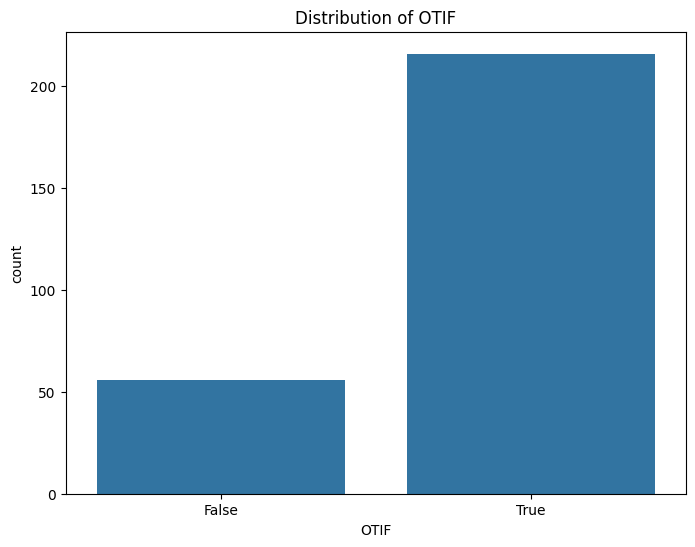


Class distribution (OTIF):
OTIF
True     79.41
False    20.59
Name: proportion, dtype: float64
Class imbalance detected - will implement balancing techniques


In [46]:
# Load the data
data = pd.read_csv('cleaned_data.csv')

# Display basic information
print("Dataset shape:", data.shape)
data.info()

# Display first 5 rows
data.head()

# Check for missing values
print("\nMissing values per column:")
print(data.isnull().sum())

# Check class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='OTIF', data=data)
plt.title('Distribution of OTIF')
plt.show()

print("\nClass distribution (OTIF):")
print(data['OTIF'].value_counts(normalize=True).mul(100).round(2))
print("Class imbalance detected - will implement balancing techniques")

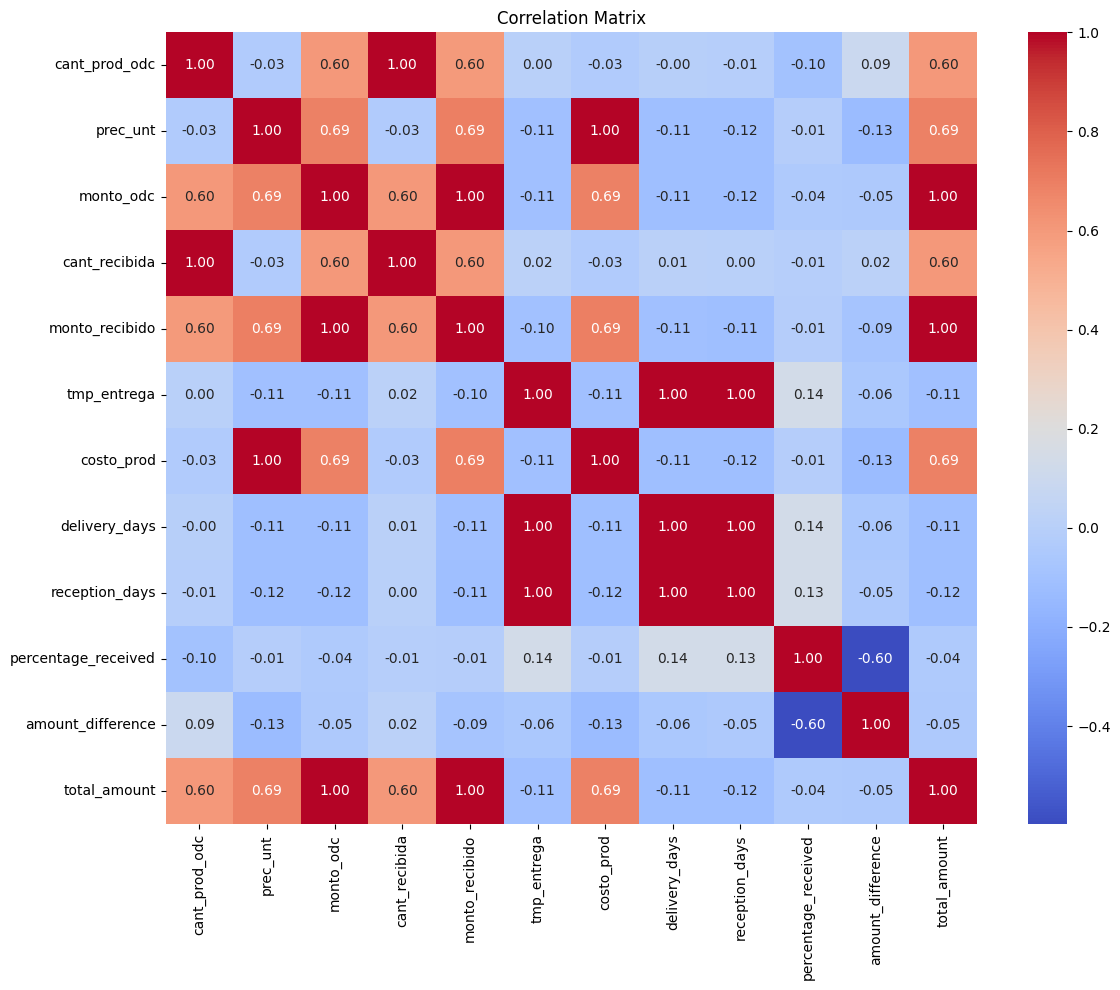

In [47]:
# Visualize correlations between numerical features
plt.figure(figsize=(12, 10))
numeric_cols = data.select_dtypes(include=['int64', 'float64']).columns
correlation_matrix = data[numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

In [48]:
# Convert date columns to datetime (if they exist in the dataset)
date_columns = [col for col in data.columns if 'fecha' in col]
for col in date_columns:
    data[col] = pd.to_datetime(data[col], errors='coerce')

In [49]:
# Feature engineering
# 1. Calculate delivery time difference (if applicable)
if 'fecha_recibido' in data.columns and 'fecha_entrega' in data.columns:
    data['delivery_time_diff'] = (data['fecha_recibido'] - data['fecha_entrega']).dt.days

# 2. Calculate quantity difference ratio (if applicable)
if 'cant_recibida' in data.columns and 'cant_prod_odc' in data.columns:
    data['quantity_diff_ratio'] = (data['cant_recibida'] - data['cant_prod_odc']) / data['cant_prod_odc']

# 3. Extract month and day of week for each date
for col in date_columns:
    data[f'{col}_month'] = data[col].dt.month
    data[f'{col}_dayofweek'] = data[col].dt.dayofweek

In [50]:
# Define features to exclude
exclude_cols = ['OTIF', 'ontime'] 
if 'nro_odc' in data.columns:
    exclude_cols.append('nro_odc')
exclude_cols.extend(date_columns)

# Define potential features
categorical_features = [col for col in data.select_dtypes(include=['object']).columns 
                        if col not in exclude_cols]
numeric_features = [col for col in data.select_dtypes(include=['int64', 'float64']).columns 
                    if col not in exclude_cols and col != 'OTIF']

print("\nCategorical features:", categorical_features)
print("\nNumeric features:", numeric_features)


Categorical features: ['cod_prod', 'cod_prov', 'estado_odc', 'nom_prov', 'org_pais', 'descrip_prod', 'Categoria', 'Subcategoria', 'und_prod']

Numeric features: ['cant_prod_odc', 'prec_unt', 'monto_odc', 'cant_recibida', 'monto_recibido', 'tmp_entrega', 'costo_prod', 'delivery_days', 'reception_days', 'percentage_received', 'amount_difference', 'total_amount', 'delivery_time_diff', 'quantity_diff_ratio']


In [51]:
# Prepare data for feature selection
X_categorical = data[categorical_features].copy()
X_numeric = data[numeric_features].copy()
y = data['OTIF']

# Process categorical data for feature selection
cat_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_cat_encoded = cat_encoder.fit_transform(X_categorical)

# Combine with numeric features
X_combined = np.hstack([X_numeric, X_cat_encoded])

# Feature selection - find top 10 features
selector = SelectKBest(score_func=mutual_info_classif, k=10)
X_selected = selector.fit_transform(X_combined, y)

# Get selected feature names
selected_numeric_indices = [i for i, selected in enumerate(selector.get_support()) 
                           if selected and i < len(numeric_features)]
selected_cat_indices = [i - len(numeric_features) for i, selected in enumerate(selector.get_support()) 
                       if selected and i >= len(numeric_features)]

selected_numeric_features = [numeric_features[i] for i in selected_numeric_indices]

# Get selected categorical features (this is more complex due to one-hot encoding)
cat_feature_names = cat_encoder.get_feature_names_out(categorical_features)
selected_cat_features = [cat_feature_names[i] for i in selected_cat_indices]

# Map one-hot encoded feature names back to original categorical features
selected_categorical_features = []
for encoded_feature in selected_cat_features:
    for cat_feature in categorical_features:
        if cat_feature in encoded_feature:
            if cat_feature not in selected_categorical_features:
                selected_categorical_features.append(cat_feature)

print("\nTop 10 features selected:")
print("Numeric features:", selected_numeric_features)
print("Categorical features:", selected_categorical_features)


Top 10 features selected:
Numeric features: ['cant_prod_odc', 'prec_unt', 'monto_odc', 'cant_recibida', 'monto_recibido', 'costo_prod', 'reception_days', 'amount_difference', 'total_amount', 'delivery_time_diff']
Categorical features: []


In [52]:
# Now prepare the final feature set for model training
final_numeric_features = selected_numeric_features
final_categorical_features = selected_categorical_features

# Split the data using only selected features
X = data[final_numeric_features + final_categorical_features].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Create preprocessing pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, final_numeric_features),
        ('cat', categorical_transformer, final_categorical_features)
    ]
)

In [53]:
# Define models to evaluate with class balancing approaches
models = {
    # 1. With class weights (for models that support it)
    'LogisticRegression_Weighted': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42))
    ]),
    'RandomForest_Weighted': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42))
    ]),
    'GradientBoosting_Weighted': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', GradientBoostingClassifier(random_state=42))  # Note: GB doesn't directly support class_weight
    ]),
    
    # 2. With SMOTE resampling
    'LogisticRegression_SMOTE': ImbPipeline([
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('classifier', LogisticRegression(max_iter=1000, random_state=42))
    ]),
    'RandomForest_SMOTE': ImbPipeline([
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
    ]),
    'GradientBoosting_SMOTE': ImbPipeline([
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('classifier', GradientBoostingClassifier(random_state=42))
    ])
}


Training LogisticRegression_Weighted...
Accuracy: 0.8824
F1 Score: 0.9231
AUC: 0.9074

Classification Report:
              precision    recall  f1-score   support

       False       0.67      0.86      0.75        14
        True       0.96      0.89      0.92        54

    accuracy                           0.88        68
   macro avg       0.81      0.87      0.84        68
weighted avg       0.90      0.88      0.89        68



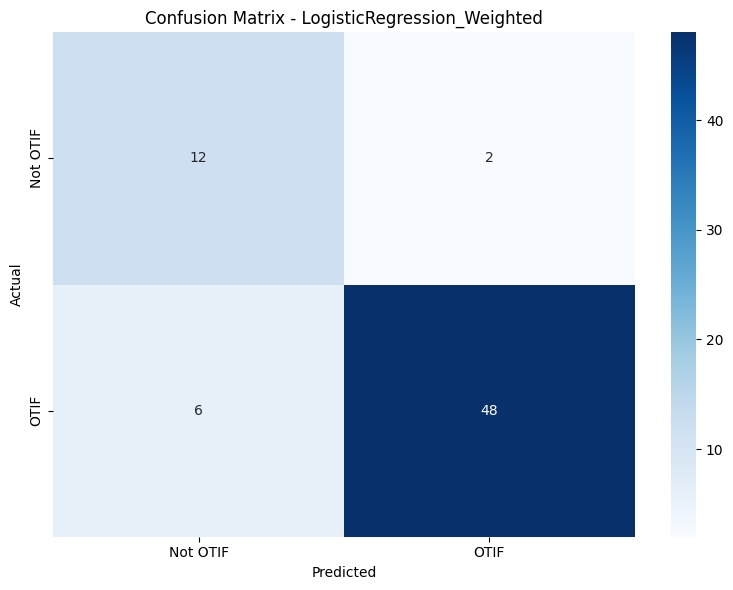

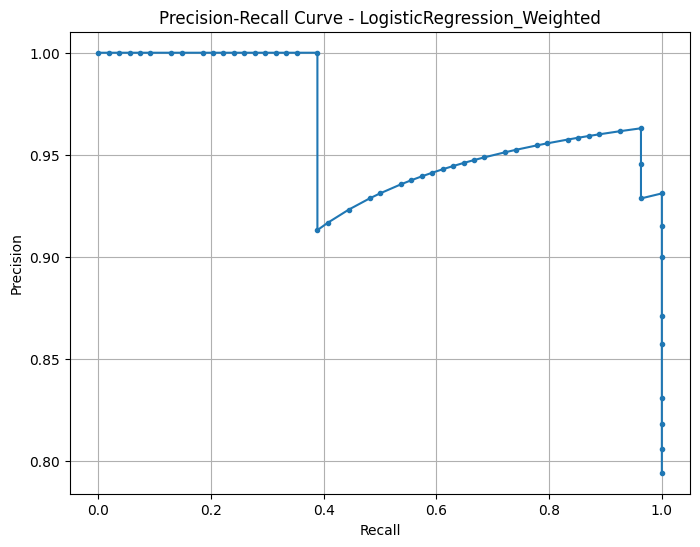


Training RandomForest_Weighted...
Accuracy: 1.0000
F1 Score: 1.0000
AUC: 1.0000

Classification Report:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00        14
        True       1.00      1.00      1.00        54

    accuracy                           1.00        68
   macro avg       1.00      1.00      1.00        68
weighted avg       1.00      1.00      1.00        68



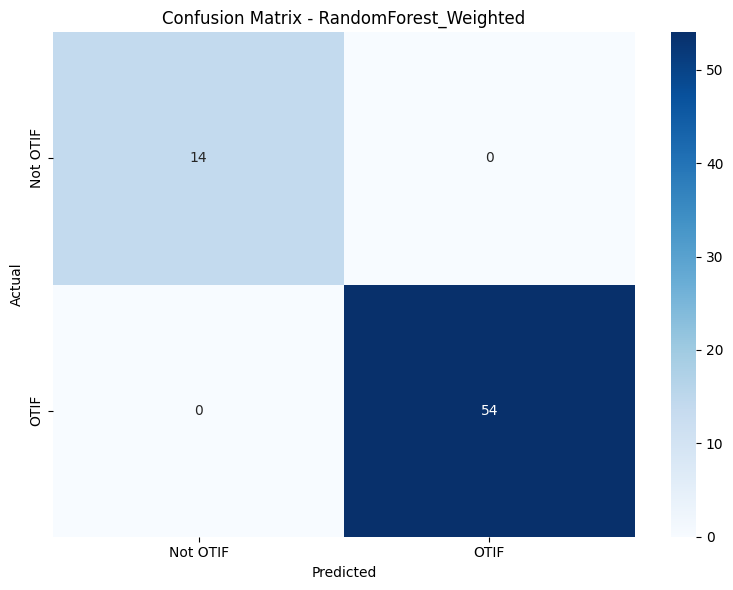

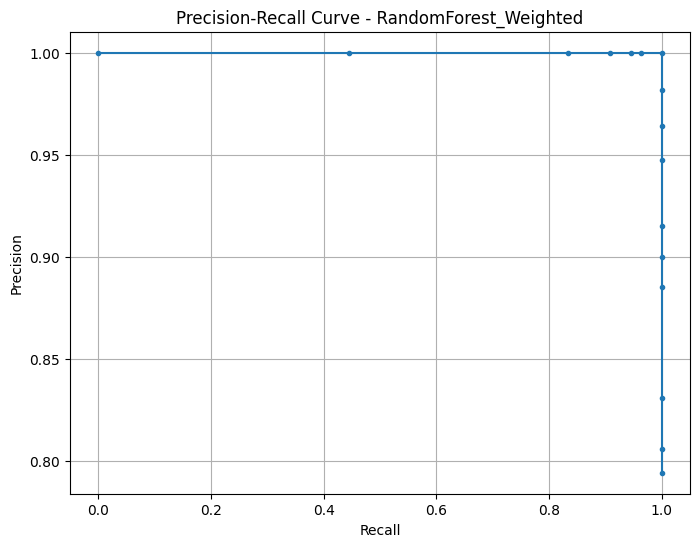


Training GradientBoosting_Weighted...
Accuracy: 1.0000
F1 Score: 1.0000
AUC: 1.0000

Classification Report:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00        14
        True       1.00      1.00      1.00        54

    accuracy                           1.00        68
   macro avg       1.00      1.00      1.00        68
weighted avg       1.00      1.00      1.00        68



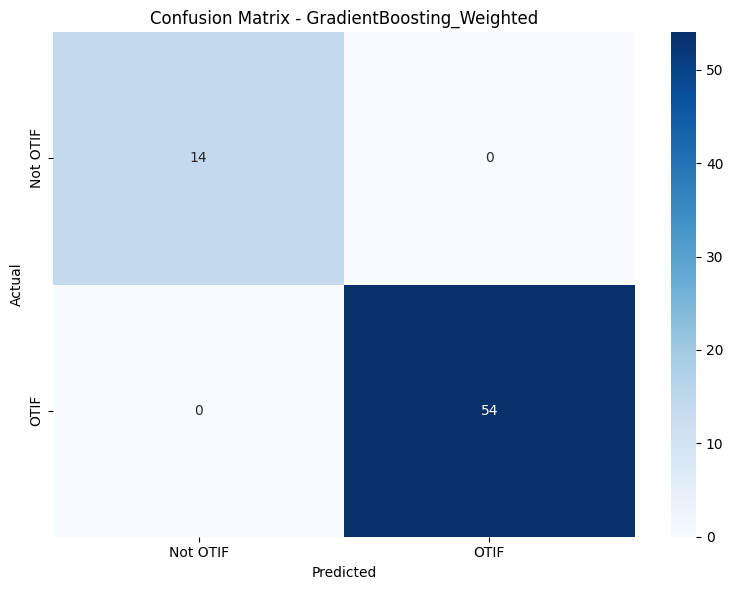

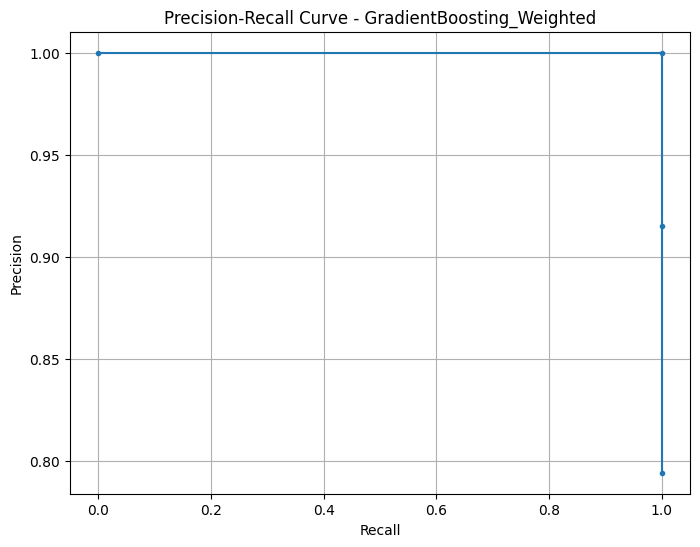


Training LogisticRegression_SMOTE...
Accuracy: 0.8676
F1 Score: 0.9126
AUC: 0.9127

Classification Report:
              precision    recall  f1-score   support

       False       0.63      0.86      0.73        14
        True       0.96      0.87      0.91        54

    accuracy                           0.87        68
   macro avg       0.80      0.86      0.82        68
weighted avg       0.89      0.87      0.87        68



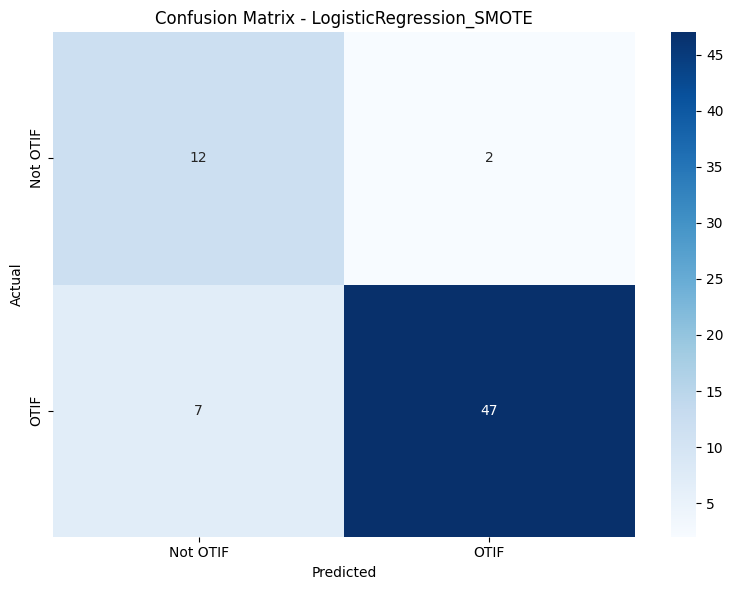

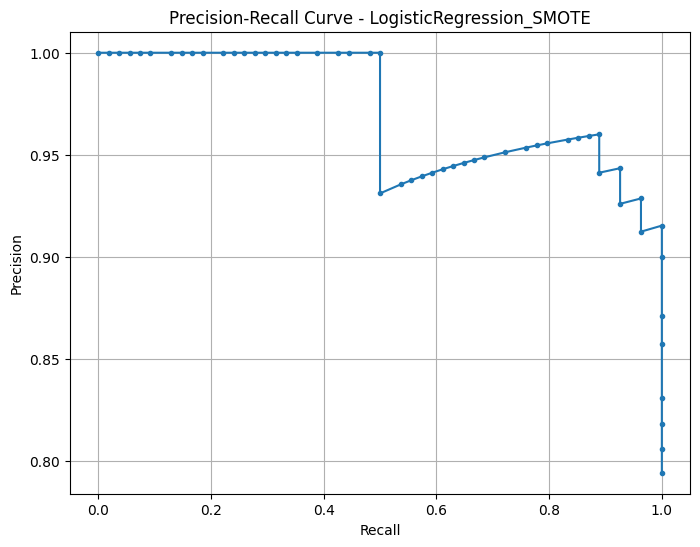


Training RandomForest_SMOTE...
Accuracy: 1.0000
F1 Score: 1.0000
AUC: 1.0000

Classification Report:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00        14
        True       1.00      1.00      1.00        54

    accuracy                           1.00        68
   macro avg       1.00      1.00      1.00        68
weighted avg       1.00      1.00      1.00        68



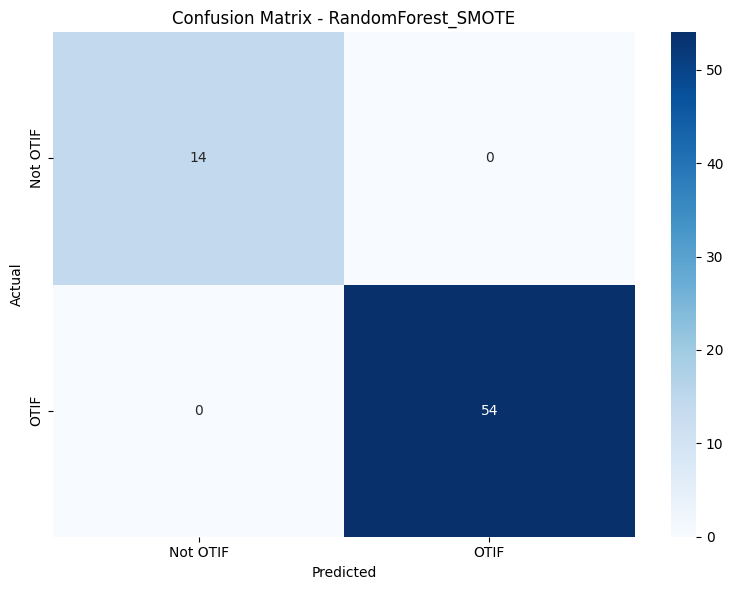

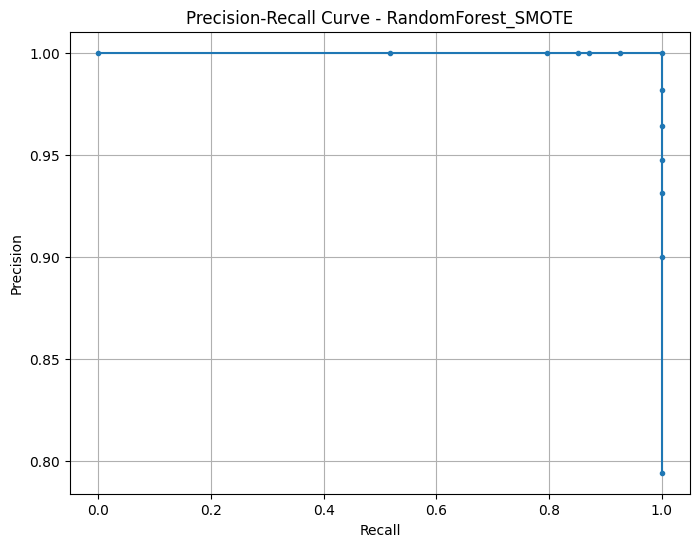


Training GradientBoosting_SMOTE...
Accuracy: 1.0000
F1 Score: 1.0000
AUC: 1.0000

Classification Report:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00        14
        True       1.00      1.00      1.00        54

    accuracy                           1.00        68
   macro avg       1.00      1.00      1.00        68
weighted avg       1.00      1.00      1.00        68



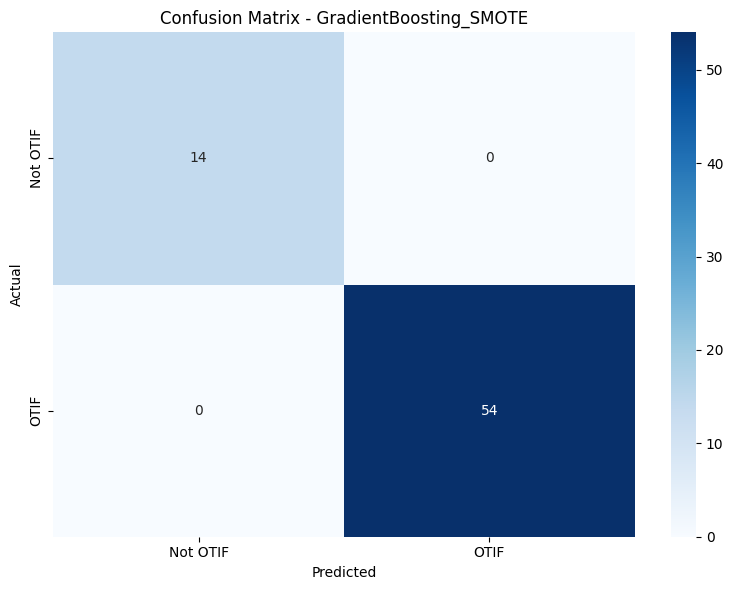

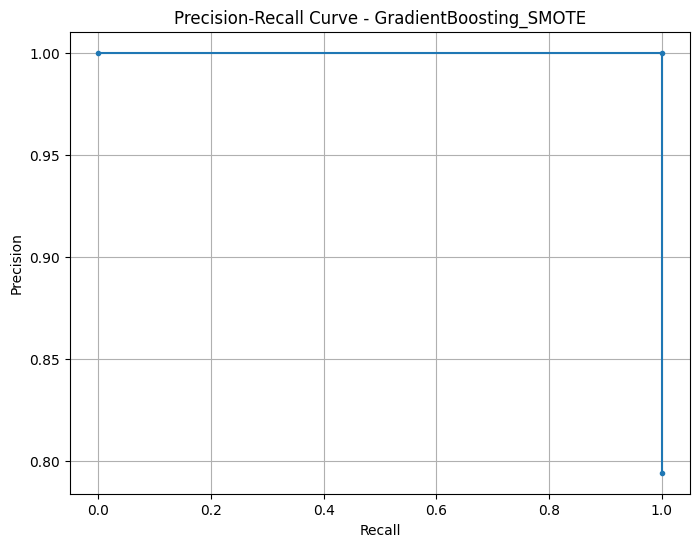


Best Model: RandomForest_Weighted
F1 Score: 1.0000
AUC: 1.0000
Best model saved as 'best_otif_model.pkl'


In [54]:
# Train and evaluate each model
results = {}
for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Train model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # For probability-based metrics
    y_prob = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_prob)
        
    results[name] = {
        'accuracy': accuracy,
        'f1': f1,
        'auc': auc,
        'model': model
    }
    
    # Print results
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC: {auc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
               xticklabels=['Not OTIF', 'OTIF'], 
               yticklabels=['Not OTIF', 'OTIF'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {name}')
    plt.tight_layout()
    plt.show()
    
    # Plot Precision-Recall curve (better for imbalanced data)
    plt.figure(figsize=(8, 6))
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    plt.plot(recall, precision, marker='.')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - {name}')
    plt.grid(True)
    plt.show()

# Find best model based on F1 score (better for imbalanced data than accuracy)
best_model_name = max(results, key=lambda x: results[x]['f1'])
best_model = results[best_model_name]['model']
print(f"\nBest Model: {best_model_name}")
print(f"F1 Score: {results[best_model_name]['f1']:.4f}")
print(f"AUC: {results[best_model_name]['auc']:.4f}")

# Save the best model
joblib.dump(best_model, 'best_otif_model.pkl')
print("Best model saved as 'best_otif_model.pkl'")

In [55]:
# Find optimal threshold based on precision-recall curve
# This can improve performance on imbalanced data
y_prob = best_model.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

# Find threshold that maximizes F1 score
f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1])
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

print(f"\nOptimal probability threshold: {optimal_threshold:.4f}")
print(f"At this threshold - Precision: {precision[optimal_idx]:.4f}, Recall: {recall[optimal_idx]:.4f}")


Optimal probability threshold: 0.9100
At this threshold - Precision: 1.0000, Recall: 1.0000



Creating a sample dataframe for predictions...

Sample data for prediction:
     cant_prod_odc  prec_unt  monto_odc  cant_recibida  monto_recibido  \
205             45       300      13500             45           13500   
106             67      1050      70350             67           70350   
166             65       250      16250             65           16250   
65              43       300      12900             43           12900   
50              19      1100      20900             19           20900   

     costo_prod  reception_days  amount_difference  total_amount  \
205         300               5                  0         13500   
106        1050               3                  0         70350   
166         250              15                  0         16250   
65          300               1                  0         12900   
50         1100              15                  0         20900   

     delivery_time_diff  
205                   0  
106              

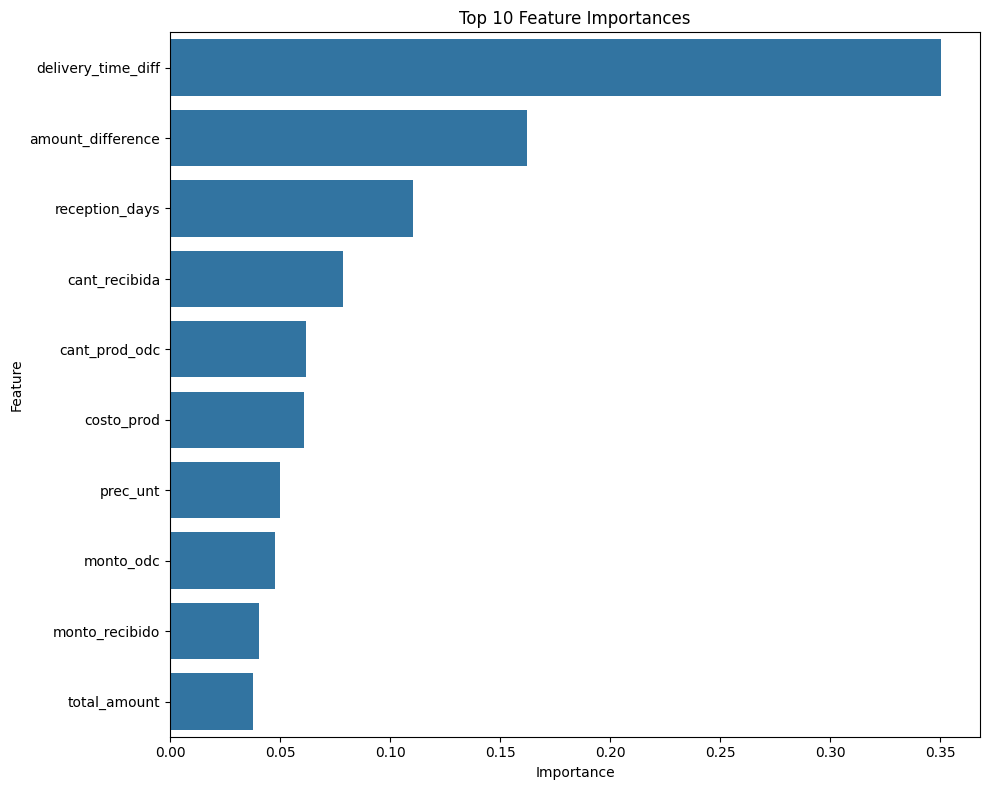

In [56]:
# Create a new dataframe for making predictions
print("\nCreating a sample dataframe for predictions...")

# Method 1: Use a subset of test data as "new" data for demonstration
new_data = X_test.iloc[:5].copy()
print("\nSample data for prediction:")
print(new_data)

# Method 2: Create synthetic data
synthetic_data = {}
for col in final_numeric_features:
    synthetic_data[col] = np.random.randint(1, 100, size=3)
for col in final_categorical_features:
    unique_values = data[col].unique()
    synthetic_data[col] = np.random.choice(unique_values, size=3)

synthetic_df = pd.DataFrame(synthetic_data)
print("\nSynthetic data for prediction:")
print(synthetic_df)

# Make predictions with both real and synthetic data
print("\nPredictions for test sample data:")
sample_probs = best_model.predict_proba(new_data)[:, 1]
sample_preds = (sample_probs >= optimal_threshold).astype(bool)  # Using the optimal threshold
for i in range(len(new_data)):
    print(f"Sample {i+1}: OTIF = {bool(sample_preds[i])}, Probability = {sample_probs[i]:.2f}")

print("\nPredictions for synthetic data:")
synthetic_probs = best_model.predict_proba(synthetic_df)[:, 1]
synthetic_preds = (synthetic_probs >= optimal_threshold).astype(bool)  # Using the optimal threshold
for i in range(len(synthetic_df)):
    print(f"Sample {i+1}: OTIF = {bool(synthetic_preds[i])}, Probability = {synthetic_probs[i]:.2f}")

# Create a function to make predictions on new data with optimal threshold
def predict_otif(new_data_df, model_file='best_otif_model.pkl', threshold=0.5):
    """
    Make OTIF predictions on new data
    
    Args:
        new_data_df: DataFrame with new data
        model_file: Path to saved model file
        threshold: Classification threshold (default=0.5, optimal value determined above)
        
    Returns:
        DataFrame with original data and predictions
    """
    # Load model
    model = joblib.load(model_file)
    
    # Make predictions
    probabilities = model.predict_proba(new_data_df)[:, 1]
    predictions = (probabilities >= threshold).astype(bool)
    
    # Create result dataframe
    result_df = new_data_df.copy()
    result_df['OTIF_Predicted'] = predictions
    result_df['OTIF_Probability'] = probabilities
    
    return result_df

# Example usage with optimal threshold
prediction_results = predict_otif(synthetic_df, threshold=optimal_threshold)
print("\nFinal prediction results with optimal threshold:")
print(prediction_results[['OTIF_Predicted', 'OTIF_Probability']])

# Analyze feature importance for the best model
def analyze_feature_importance(model, feature_names):
    """Extract and display feature importance from the model if available"""
    # Get the classifier from the pipeline
    if hasattr(model, 'named_steps'):
        if 'classifier' in model.named_steps:
            classifier = model.named_steps['classifier']
        else:
            print("Could not extract classifier from pipeline")
            return
    else:
        classifier = model
    
    # Check if model provides feature importance
    if hasattr(classifier, 'feature_importances_'):
        importances = classifier.feature_importances_
    elif hasattr(classifier, 'coef_'):
        importances = np.abs(classifier.coef_[0])
    else:
        print("Model doesn't provide feature importance information")
        return
    
    # Create DataFrame with feature importances
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    # Display top 10 features
    print("\nTop 10 feature importances:")
    print(importance_df.head(10))
    
    # Plot feature importances
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature', data=importance_df.head(10))
    plt.title('Top 10 Feature Importances')
    plt.tight_layout()
    plt.show()

# If possible, analyze feature importance of the best model
try:
    # For this to work, we'd need the transformed feature names from the pipeline
    # This is a simplified approach
    all_features = final_numeric_features + final_categorical_features
    analyze_feature_importance(best_model, all_features)
except Exception as e:
    print(f"Could not analyze feature importance: {e}")